In [ ]:
!pip install py-rouge
from google.colab import drive
drive.mount('/content/drive')

Based on Rouge-L score of summaries generated on various beam size, we chose beam size 2 for BART finetuned on optimized hyperparameters and beam size 5 for PEGASUS. 

In [2]:
# load generated test summaries for both BART and PEGASUS

import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

bart = pd.read_csv('/content/drive/MyDrive/NLP Summarization Project/Generated Summaries/1f BART_finetuned on optimal hp_beam2.csv')
pegasus = pd.read_csv('/content/drive/MyDrive/NLP Summarization Project/Generated Summaries/1b PEGASUS_beam5.csv')

bart['model'] = 'BART'
pegasus['model'] = 'PEGASUS'

df = pd.concat([bart, pegasus])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Differences in generated summary length
We first examine the distribution of generated summary length for both models. On average, BART generates longer summaries than PEGASUS, though PEGASUS has two separate peaks of lengths, while BART's summaries are clustered around the median of 54 tokens.

In [3]:
# use tokenizer to tokenize the generated summaries and look at the distributions

df['generated_summary_length'] = df['generated'].apply(lambda x: len(word_tokenize(x)))
df.groupby('model').describe()[['generated_summary_length']]

generated_summary_length                        ...                    
                           count       mean        std  ...   50%    75%    max
model                                                   ...                    
BART                     92750.0  55.113747   8.113873  ...  54.0   59.0  140.0
PEGASUS                  92750.0  67.204377  47.837925  ...  41.0  126.0  428.0

[2 rows x 8 columns]

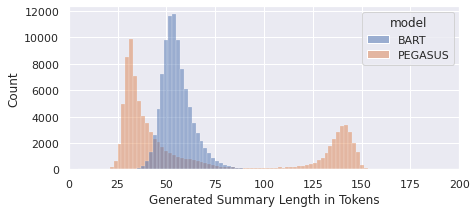

In [4]:
# histogram of summary length color coded by model

f, ax = plt.subplots(figsize=(7, 3))

sns.histplot(df, x="generated_summary_length", hue="model", binwidth = 2, ax = ax)

ax.set(xlim = (0, 200), xlabel = "Generated Summary Length in Tokens")
plt.show()

## Difference in summary quality

Next, we want to see how much the models rely on the earlier sections of the input article when generating summaries. The first 100 words (roughly split based on spaces) of the article is used as reference to evaluate ROUGE-1 and ROUGE-2 scores of the generated summaries. Conceptually, if the ROUGE score is high, then the summary is mainly gathered from the beginning of the article.

The resulting histogram shows PEGASUS having an obvious peak of ROUGE-2 score of 1. Subdividing PEGASUS summaries based on length shows that long summaries accounts for all summaries with ROUGE-2 score, implying that these generated summaries are essentially copying the entire beginning section of the article.

In [5]:
import rouge

evaluator = rouge.Rouge(metrics=['rouge-n'],
                           max_n=2,
                           limit_length=True,
                           length_limit=150,
                           length_limit_type='words',
                           apply_avg=False,
                           apply_best=False,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

hypothesis = df['generated'].tolist()

# the reference is roughly the first 100 words of the article
reference = df['article'].apply(lambda x: ' '.join(x.split()[:100])).tolist()

scores = evaluator.get_scores(hypothesis, reference)

df['rouge2r_of_article'] = [x['r'][0] for x in scores['rouge-2']]

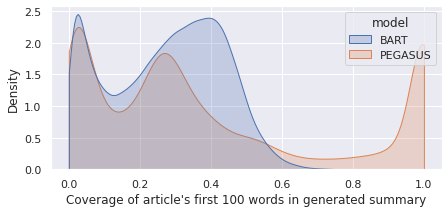

In [19]:
# histogram of PEGASUS and BART summary ROUGE-2 Recall using the first 100 words of the article as reference
f, ax = plt.subplots(figsize=(7, 3))

sns.kdeplot( data = df, x = 'rouge2r_of_article', hue = 'model', fill = True, common_norm=False, clip = (0,1), ax = ax)

ax.set(xlabel = "Coverage of article's first 100 words in generated summary")

plt.show()

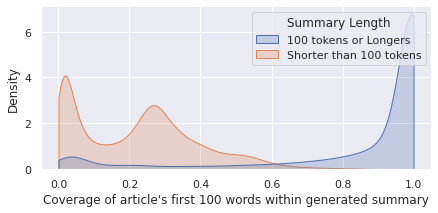

In [33]:
# isolate PEGASUS records only, create a new column indicating whether the summary length belongs to the first or the second peak seen in histogram
pegasus = df[df['model'] == 'PEGASUS'].copy()
pegasus['Summary Length'] = (pegasus['generated_summary_length'] < 100).replace({True: 'Shorter than 100 tokens', False: '100 tokens or Longers'})

# plot histogram of rouge score color coded by whether the pegasus summary is in the first or second peak
f, ax = plt.subplots(figsize=(7, 3))

sns.kdeplot( data = pegasus, x = 'rouge2r_of_article', hue = 'Summary Length', fill = True, common_norm=False, clip = (0,1), ax = ax)

ax.set(xlabel = "Coverage of article's first 100 words within generated summary")

plt.show()

In [ ]:
# descriptive stats of ROUGE-score PEGASUS summaries referencing the article, grouped by summary length
pegasus.groupby('Summary Length').describe().stack()[['rouge1f', 'rouge2f', 'rougeLf', 'rouge1r', 'rouge2r', 'rougeLr']]

rouge1f  ...       rougeLr
Summary Length                               ...              
100 tokens or Longers   count  26077.000000  ...  26077.000000
                        mean       0.170199  ...      0.582502
                        std        0.085833  ...      0.236126
                        min        0.000000  ...      0.000000
                        25%        0.104348  ...      0.400312
                        50%        0.157143  ...      0.536505
                        75%        0.229730  ...      0.762475
                        max        0.937008  ...      1.000000
Shorter than 100 tokens count  66673.000000  ...  66673.000000
                        mean       0.347683  ...      0.451142
                        std        0.212764  ...      0.266152
                        min        0.000000  ...      0.000000
                        25%        0.185185  ...      0.246671
                        50%        0.300000  ...      0.371087
                        75%        0.476190  ...      0.612735
                        max        1.000000  ...      1.000000

[16 rows x 6 columns]

Dividing BART summaries at the median length shows much smaller difference in how much the two groups of summaries quote the beginning portion of the articles. The longer summaries have slightly higher ROUGE-2 recall so those quote the beginning of the articles a bit more.

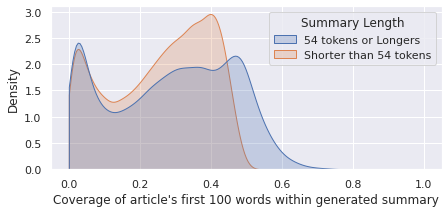

In [34]:
# 54 is the median length for BART length
bart = df[df['model'] == 'BART'].copy()
bart['Summary Length'] = (bart['generated_summary_length'] < 54).replace({True: 'Shorter than 54 tokens', False: '54 tokens or Longers'})

f, ax = plt.subplots(figsize=(7, 3))

sns.kdeplot( data = bart, x = 'rouge2r_of_article', hue = 'Summary Length', fill = True, common_norm=False, clip = (0,1), ax = ax)

ax.set(xlabel = "Coverage of article's first 100 words within generated summary")

plt.show()

In [ ]:
# descriptive stats of ROUGE-score BART summaries referencing the article, grouped by summary length

bart.groupby('Summary Length').describe().stack()[['rouge1f', 'rouge2f', 'rougeLf', 'rouge1r', 'rouge2r', 'rougeLr']]

rouge1f  ...       rougeLr
Summary Length                              ...              
54 tokens or Longers   count  48520.000000  ...  48520.000000
                       mean       0.275103  ...      0.473694
                       std        0.147523  ...      0.240448
                       min        0.000000  ...      0.000000
                       25%        0.162791  ...      0.294656
                       50%        0.250000  ...      0.400312
                       75%        0.366197  ...      0.612735
                       max        1.000000  ...      1.000000
Shorter than 54 tokens count  44230.000000  ...  44230.000000
                       mean       0.306870  ...      0.462048
                       std        0.169182  ...      0.245743
                       min        0.000000  ...      0.000000
                       25%        0.179104  ...      0.277009
                       50%        0.273973  ...      0.400312
                       75%        0.407407  ...      0.603437
                       max        1.000000  ...      1.000000

[16 rows x 6 columns]